# Flowers Classification
## 개요
- tensorflow_datasets에 포함된 tf_flowers 데이터를 활용하여 Image Classification Task를 진행합니다.
- 모델 성능을 고도화하기 위해 Pre-trained Model을 활용합니다.

## 목차
1. 데이터셋 내려받기
2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기
3. 모델 설계하기
4. 모델 학습시키기
5. 모델 성능 평가하기
6. 모델 활용하기

## 회고

## Reference
---

## 1. 데이터셋 내려받기

In [22]:
# 텐서 플로우 버전 확인
import tensorflow as tf
print(tf.__version__)

2.6.0


### tf.flowers datasets 살펴보기
- [tf.flowers 공식문서](https://www.tensorflow.org/datasets/catalog/tf_flowers) 에서 데이터를 살펴봅니다.
- 데이터의 용량 : 218.21 MiB
- 이미지 데이터의 개수 : train data 3,670개
- label의 class 개수(꽃의 종류) : num_classes=5 (총 5종류의 꽃이 있는 데이터셋 입니다.)

In [23]:
# tensorflow에서 제공하는 datasets 사용
import tensorflow_datasets as tfds

ds = tfds.load('tf_flowers', split='train', shuffle_files=True)
assert isinstance(ds, tf.data.Dataset)
print(ds)

<_OptionsDataset shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>


In [24]:
tfds.__version__

# tf_flowers데이터셋을 다운로드 받았는데 cats_vs_dogs의 버전이 확인됨. 다운로드 재시도

'4.4.0'

In [25]:
# tf_flowers 데이터셋 다운로드
dataset_name = "tf_flowers"
dataset, info = tfds.load(name=dataset_name, split="train", with_info=True)
print(info)

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/aiffel/tensorflow_datasets/tf_flowers/3.0.1',
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)


Image Shape: (333, 500, 3)
Label: 2


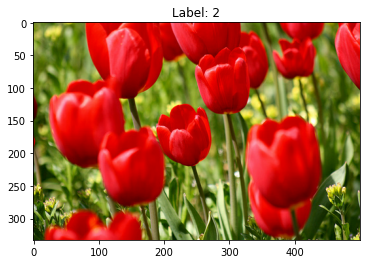

In [26]:
# 데이터셋에서 샘플 확인
for example in dataset.take(1):
    image, label = example["image"], example["label"]
    
    # 이미지 및 레이블 정보 출력
    print(f"Image Shape: {image.shape}")
    print(f"Label: {label}")
    
    # 이미지 시각화
    import matplotlib.pyplot as plt
    
    plt.imshow(image.numpy())
    plt.title(f"Label: {label}")
    plt.show()

In [27]:
# 데이터 가져오기
!mkdir -p ~/aiffel/flowers/FlowersImages    # ~/aiffel/flowers/FlowersImages 경로에 디렉토리를 생성
!ln -s ~/data/* ~/aiffel/flowers            # ~/aiffel/flowers 디렉토리에 심볼릭 링크로 연결합니다.

In [28]:
# 계속 cats_vs_dogs 데이터가 다운로드 됨. -> 해당 파일 삭제
import os

# 해당 경로에 있는 파일 또는 디렉토리 삭제
path_to_remove = '/aiffel/aiffel/flowers/cats_vs_dogs'

try:
    os.system(f"rm -rf {path_to_remove}")
    print(f"Successfully removed: {path_to_remove}")
except Exception as e:
    print(f"Error while removing: {e}")

Successfully removed: /aiffel/aiffel/flowers/cats_vs_dogs


In [29]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import warnings
warnings.filterwarnings(action='ignore')

In [30]:
# datasets download 재시도

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

# pathlib 모듈을 임포트합니다. 이 모듈은 파일 시스템 경로를 다루는데 유용한 클래스를 제공합니다
# 다운로드할 데이터셋의 URL을 지정합니다. (TensorFlow에서 제공하는 꽃 이미지 데이터셋의 URL)
# get_file 함수를 사용하여 데이터셋을 다운로드하고 압축을 해제합니다. 이 함수는 다운로드된 파일의 경로를 반환합니다.
# origin 매개변수에는 다운로드할 파일의 URL을, extract 매개변수에는 압축을 해제할지 여부를 지정
# pathlib.Path를 사용하여 다운로드된 파일의 경로를 처리합니다. 
# >> with_suffix('')를 사용하여 파일의 확장자를 제거하고, 이를 data_dir에 저장합니다. 
# >> 이렇게 하면 압축이 해제된 데이터셋이 저장된 디렉토리의 경로가 얻어집니다.

In [31]:
# image 개수 출력
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [32]:
# 파일이 저장된 경로 확인
print(data_dir)

/aiffel/.keras/datasets/flower_photos


In [35]:
# 데이터셋을 로컬에 다운로드 하기

import shutil

# 로컬 디렉토리 지정
local_data_dir = '/aiffel/aiffel/flowers'

# 로컬 디렉토리에 데이터 복사
shutil.copytree(data_dir, local_data_dir)

# 복사된 데이터 디렉토리 경로 출력
print(f"Data copied to: {local_data_dir}")

FileExistsError: [Errno 17] File exists: '/aiffel/aiffel/flowers'

로컬에 있는 flowers 디렉토리에 다운로드하려 하였으나 flowers 디렉토리가 이미 존재하여 오류 발생.  
기존의 flowers 디렉토리에 다시 다운로드 합니다.

In [36]:
# 기존 디렉토리 내에 다운로드하기 
import tensorflow as tf
import tensorflow_datasets as tfds

# 기존 디렉토리 경로
existing_data_dir = '/aiffel/aiffel/flowers'

# TensorFlow Datasets에서 데이터셋 다운로드
dataset_name = "tf_flowers"
dataset, info = tfds.load(name=dataset_name, split="train", with_info=True, data_dir=existing_data_dir)

# 데이터셋 정보 출력
print(info)

# 기존 디렉토리에 저장된 파일 수 확인
image_count = len(list(existing_data_dir.glob('*/*.jpg')))
print(f"Number of images in the existing directory: {image_count}")


tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='/aiffel/aiffel/flowers/tf_flowers/3.0.1',
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)


AttributeError: 'str' object has no attribute 'glob'

데이터셋 다운로드와 정보 출력은 정상 작동하였으나, 디렉토리에 저장된 파일 수 확인 부분만 오류가 발생하여 재시도하였습니다.  
실제로 확인이 필요한 data_dir의 파일 수를 확인하였습니다. (오류 코드에서는 existing_data_dir를 확인하였으나 불필요하므로)

In [37]:
# 기존 디렉토리에 저장된 파일 수 확인
from pathlib import Path  # pathlib 라이브러리의 Path 클래스를 임포트

# 디렉토리 경로 설정
data_dir = '/aiffel/aiffel/flowers/tf_flowers/3.0.1'

image_count = len(list(Path(data_dir).glob('*/*.jpg')))
print(f"Number of images in the existing directory: {image_count}")

Number of images in the existing directory: 0


In [38]:
!mkdir -p ~/aiffel/flowers/FlowersImages   # ~/aiffel/flowers/FlowersImages 경로에 디렉토리를 생성
!ln -s ~/data/* ~/aiffel/flowers/

# ln은 링크를 생성하는 명령어입니다.
# -s 옵션은 심볼릭 링크를 생성하는 옵션입니다.
# ~/data/*는 ~/data/ 디렉토리 안의 모든 파일에 대한 패턴입니다.
# 이를 ~/aiffel/cats_vs_dogs/ 디렉토리에 심볼릭 링크로 연결합니다.

ln: failed to create symbolic link '/aiffel/aiffel/flowers/cat_face.jpg': File exists
ln: failed to create symbolic link '/aiffel/aiffel/flowers/my_cat.jpg': File exists
ln: failed to create symbolic link '/aiffel/aiffel/flowers/my_dog.jpg': File exists


In [39]:
# 계속 cats_vs_dogs 데이터가 다운로드 됨. -> 해당 파일 삭제
import os

# 해당 경로에 있는 파일 또는 디렉토리 삭제
path_to_remove = '/aiffel/aiffel/flowers/cats_vs_dogs'

try:
    os.system(f"rm -rf {path_to_remove}")
    print(f"Successfully removed: {path_to_remove}")
except Exception as e:
    print(f"Error while removing: {e}")

Successfully removed: /aiffel/aiffel/flowers/cats_vs_dogs


tf_flowers 디렉토리 내의 파일로 경로를 수정하였습니다.

In [40]:
!mkdir -p ~/aiffel/flowers/FlowersImages   # ~/aiffel/flowers/FlowersImages 경로에 디렉토리를 생성
!ln -s ~/aiffel/flowers/tf_flowers/* ~/aiffel/flowers/

# ln은 링크를 생성하는 명령어입니다.
# -s 옵션은 심볼릭 링크를 생성하는 옵션입니다.
# ~/data/*는 ~/data/ 디렉토리 안의 모든 파일에 대한 패턴입니다.
# 이를 ~/aiffel/cats_vs_dogs/ 디렉토리에 심볼릭 링크로 연결합니다.

ln: failed to create symbolic link '/aiffel/aiffel/flowers/3.0.1': File exists


In [41]:
# train, valid, test 데이터 나누기

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='~/aiffel/flowers/',   # data_dir='~/aiffel/flowers/': 데이터셋이 저장될 디렉토리를 지정
    download=False,   # 데이터셋을 인터넷에서 다운로드 할지? 로컬에 다운로드된 데이터셋 사용하므로 False로 설정
    with_info=True,   # 데이터셋의 메타데이터도 함께 로드할지 여부를 결정
    as_supervised=True,
)

In [42]:
# 각각의 데이터셋 확인하기
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [43]:
# 이미지 시각화
import matplotlib.pyplot as plt

plt.imshow(raw_train.numpy())
plt.title(f"Label: {label}")
plt.show()

AttributeError: 'PrefetchDataset' object has no attribute 'numpy'

## 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기
datasets을 모델에 활용할 수 있도록 전처리합니다.

In [ ]:
# 데이터 시각화를 위해 matplotlib 가져오기

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("슝~")

In [ ]:
# raw_train 안의 데이터 확인하기
# tf.data.Dataset에서 제공하는 take라는 함수를 사용하여
# take()는 인수로 받은 만큼의 개수만큼의 데이터를 추출하여 새로운 데이터셋 인스턴스를 생성하여 리턴하는 함수

plt.figure(figsize=(10, 5))

# label' 특성에 대한 int2str 메서드를 사용하여 정수 형식의 레이블을 문자열로 변환하는 함수를 정의
get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)   #  2행 5열의 서브플롯 중에 현재 인덱스에 해당하는 위치에 서브플롯을 생성
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## 3. 모델 설계하기

## 4. 모델 학습시키기

## 5. 모델 성능 평가하기

## 6. 모델 활용하기

---
## 회고
### KEEP

### PROBLEM

### TRY

---
## Reference

- [tensorflow datasets 확인](https://www.tensorflow.org/datasets/catalog/tf_flowers)
- [tensorflow datasets 다운로드](https://www.tensorflow.org/tutorials/load_data/images)